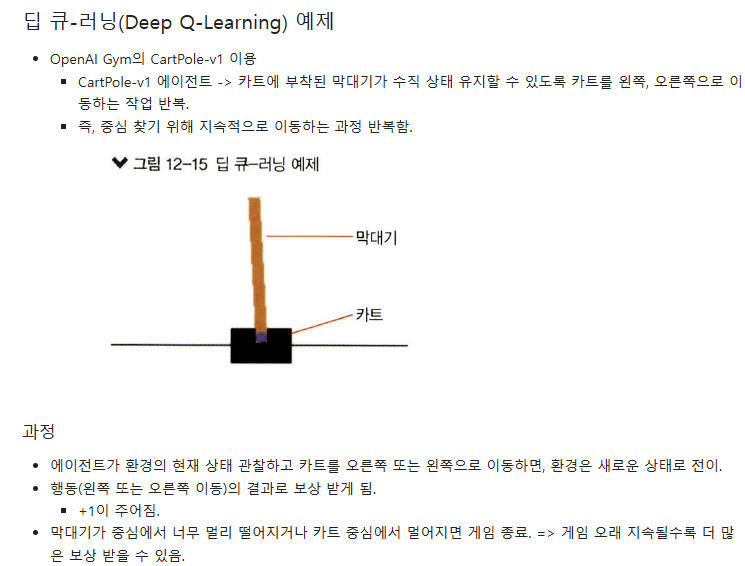

In [1]:
# 예제를 위한 패키지 설치 - gym
# 코랩에서에서 OpenAI의 gym을 활용하기 위해 다음을 설치.

!sudo apt update && apt install xvfb && pip3 install pyvirtualdisplay && pip install pyvirtualdisplay
!sudo pip install pyvirtualdisplay

# 설치 후 [런타임 다시 시작]

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
45 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InR

In [2]:
# 한글 서체 설치 # 생략 가능

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 설치 후 [런타임 다시 시작]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/X11: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/X11/encodings: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/X11/encodings/large: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/X11/misc: caching, new cache contents: 89 fonts, 0 dirs
/usr/share/fonts/X11/util: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: cachin

In [3]:
#한글깨짐 해결
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

In [4]:
# 라이브러리 호출
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple  # 튜플에 담긴 요소들의 인덱스와 값으로 모두 접근 가능
from itertools import count # 무한 루프 사용을 위한 라이브러리
from PIL import Image  # 이미지 처리를 위한 라이브러리

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('CartPole-v1').unwrapped  # cartpole이라는 강화 학습 환경 불러옴
plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [5]:
# 리플레이 메모리
# 에이전트가 관찰한 상태 전이(state transition), 상태, 행동 등을 저장하여 나중에 재사용

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

* namedtuple : 상태 전이와 관련된 정보들을 포함. 현재의 상태와 행동(state, action) -> 다음 상태와 보상(next_state, reward)으로 매핑됨.
* 리플레이 메모리(버퍼)에는 최근 관찰된 전이(transition), 현재 상태, 행동, 다음 상태, 보상 정보가 담기게 됨.
    * sample() 메서드 : 리플레이 메모리에 저장된 데이터 중 랜덤하게 배치 크기(batch_size)만큼 반환함.

In [6]:
# DQN 모델 네크워크
# CartPole 예제는 통제된 상황(에이전트의 모든 행동 예측 가능한 상황) 가정
# 현실에서는 완벽하게 통제된 상황 존재 x -> DQN 이용하여 Q 함수와 유사하도록 생성
# 학습 목표 - 누적 보상이 최대가 되는 것.

class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        def conv2d_size_out(size, kernel_size=5, stride=2):
            return (size - (kernel_size - 1) - 1) // stride + 1

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))
        # 함수 반환값은 [[left0exp, right0exp]...]와 같음.
        # 다음 행동 결정하기 위해 사용

In [7]:
# 다양한 이미지 변환 쉽게 처리할 수 있도록 패키지 설치
!pip install pyglet

In [9]:
!pip install Pillow==9.4.0

<ipython-input-10-14694dc775a2>:8: DeprecationWarning: CUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use BICUBIC or Resampling.BICUBIC instead.
  T.Resize(40, interpolation=Image.CUBIC),
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. 

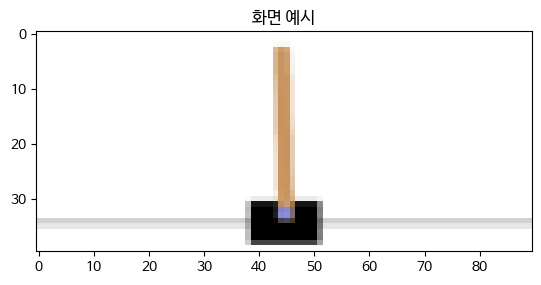

In [10]:
# 이미지 추출 및 처리
import pyglet
from pyvirtualdisplay import Display #코랩에서는 가상의 display를 생성.
display = Display(visible=False, size=(400, 300))
display.start()

resize = T.Compose([T.ToPILImage(),
                  T.Resize(40, interpolation=Image.CUBIC),
                  T.ToTensor()]) # 이미지 크기 및 텐서 변환
def get_cart_location(screen_width):  # 카트 위치 정보 가져오기
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0) # 카트 중간(중앙) 위치

def get_screen():
    screen = env.render(mode='rgb_array').transpose((2,0,1))
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height*0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)

    if cart_location < view_width //2 :
        # 카트는 출력 화면 아래쪽 중앙에 존재하므로 화면 위쪽과 아래쪽 제거
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    screen = screen[:, :, slice_range]
    # 카트가 화면 중앙에 위치하도록 가장자리 제거
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen) # 텐서로 변환
    return resize(screen).unsqueeze(0).to(device)
    # 출력 크기 조정 및 배치 차원 추가하여 데이터는 (배치, 채널, 높이, 너비) 형태 가짐.

env.reset()  # 환경 초기화
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1,2,0).numpy(),
          interpolation='none')  # permute 함수 : transpose 함수처럼 차원 바꾸어 표현
plt.title('화면 예시')
plt.show()

* get_screen() : 엡실론 욕심쟁이 정책(epsilon greedy policy)에 따라 행동(action) 선택함.
    * 행동 선택하기 위해 활용 & 탐험이라는 방법 이용.
    * 때로는 모델을 활용하게 되고 때로는 리플레이 메모리의 데이터 랜덤하게 샘플링하여 탐험함.
*screen = env.render(mode='rgb_array').transpose((2,0,1)) : gym 이용한 출력은 400x600x3 형태 갖지만 때로는 800x1200x3 형태 갖기도 함. 이때 데이터의 형태를 (채널, 높이, 너비)로 바꾸어 주어야 함.
* slice_range = slice(view_width) : 데이터 중 일부를 잘라서 가져올 때 slice 사용.
* screen = np.ascontiguousarray(screen, dtype=np.float32) / 255 : 데이터를 실수(float)로 변환하고 출력 크기를 조정함. 또한, np.ascontiguousarray -> 메모리에 연속적인 배열 반환하고자 할 때 사용.
    * 이 함수는 메모리에 연속적으로 저장되지 않는 배열을 연속적으로 저장되는 배열로 변환 => 더 빠르게 데이터 불러올 수 있음.

In [11]:
# 모델 객체화 및 손실 함수 정의
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape
n_actions = env.action_space.n   # gym에서 행동(action)에 대한 횟수 가져옴.

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
            # max(1)은 각 행의 가장 큰 열 값을 반환
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

episode_durations = []

/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


* init_screen = get_screen() : gym 출력 모양에 따라 네트워크 계층을 올바르게 초기화할 수 있도록 화면 크기를 가져옴. 이때 화면 크기는 3x40x90에 가까운데, get_screen() 함수에서 압축, 축소한 결과.
    * env.render() : 화면 크기 정보 가져옴.
    * slice() 적용하여 크기 축소함.
* target_net.load_state_dict(policy_net.state_dict())  : 모델 불러와서 파라미터 값 채워 줌.
    * load_state_dict : state_dict 값 읽고(policy_net 모델 가져와서) 모델 파라미터 값 채워 줌.
    * state_dict : 모델의 저장, 업데이트, 변경 및 복원 위해 사용함. (모델 - 모델에서 사용하는 가중치, 옵티마이저 등의 값)

In [12]:
# 모델에서 사용할 옵티마이저 정의
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                       if s is not None]) # torch.cat 이용하여 s값들을 이어 붙임.

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)  # Q(s_t, a_t) 계산
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch  # V(s_{t+1}) 계산

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()

    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)

    optimizer.step()

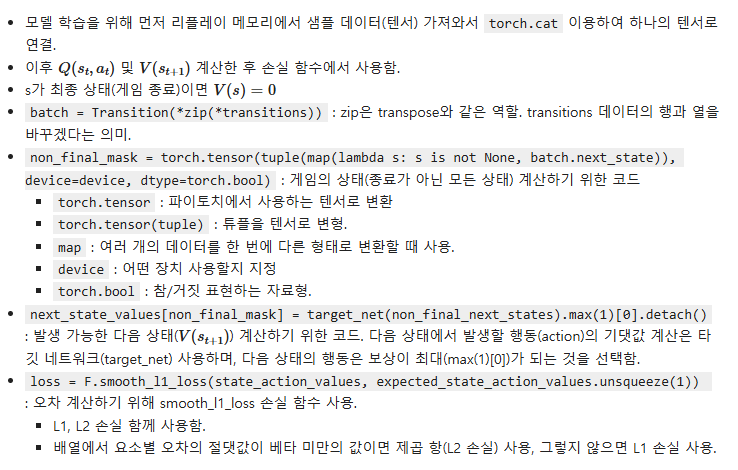

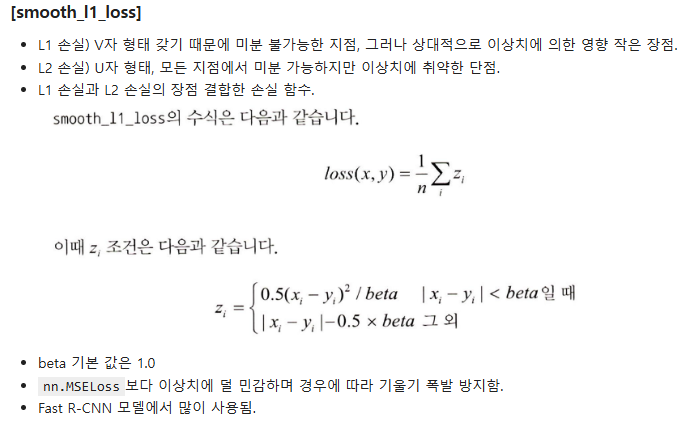

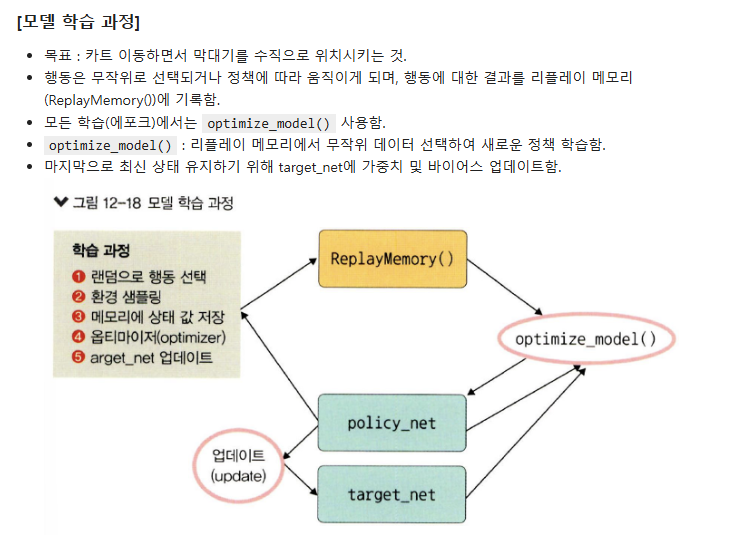

In [13]:
# 모델 학습
num_episodes = 50

for i_episode in range(num_episodes):
    env.reset()   # 환경과 상태 초기화
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen

    for t in count():
        action = select_action(state)  # 행동 선택 및 실행
        step_output = env.step(action.item())
        reward = step_output[1]  # reward is the 2nd value in the returned tuple/list
        done = step_output[2]
        # 선택된 행동(action)을 환경으로 보냄.
        reward = torch.tensor([reward], device=device)

        last_screen = current_screen
        current_screen = get_screen()

        if not done:  # 새로운 상태 관찰(observe)
            next_state = current_screen - last_screen
        else:
            next_state = None

        memory.push(state, action, next_state, reward)  # 상태 전이(state transition) 메모리에 저장
        state = next_state  # 다음 상태로 이동

        optimize_model()  # 타깃(큐) 네트워크에 대해 최적화 진행
        if done:
            episode_durations.append(t + 1)
            break

    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        # 큐 네트워크의 모든 가중치와 바이어스를 복사하여 타깃(큐) 네크워트 업데이트.

print('종료')
# env.render()  # 화면 출력
env.close()  # 화면 종료
# plt.show()

종료


In [ ]:
# 몬테카를로 트리 검색을 적용한 틱택토 게임 구현하기

In [14]:
# 보드 생성
boarder = {'1': ' ' , '2': ' ' , '3': ' ' ,
            '4': ' ' , '5': ' ' , '6': ' ' ,
            '7': ' ' , '8': ' ' , '9': ' ' }

board_keys = []

for key in boarder:
    board_keys.append(key)

In [15]:
# 화면 출력 함수 정의(1 ~ 9 사이의 숫자)
def visual_Board(board_num):
    print(board_num['1'] + '|' + board_num['2'] + '|' + board_num['3'])
    print('-+-+-')
    print(board_num['4'] + '|' + board_num['5'] + '|' + board_num['6'])
    print('-+-+-')
    print(board_num['7'] + '|' + board_num['8'] + '|' + board_num['9'])

In [16]:
# 보드 이동 함수 정의(에이전트가 보드 이동함)
def game(): # 플레이어의 보드 이동 함수
    turn = 'X'
    count = 0

    for i in range(8):
        visual_Board(boarder)
        print("당신 차례입니다," + turn + ". 어디로 이동할까요?")
        move = input()
        if boarder[move] == ' ':
            boarder[move] = turn
            count += 1
        else:
            print("이미 채워져있습니다.\n어디로 이동할까요?")
            continue

        if count >= 5: # 플레이어 X or Y가 5번 이동 후 이겼는지 확인함
            if boarder['1'] == boarder['2'] == boarder['3'] != ' ': # 상단에 1, 2, 3 채워짐
                visual_Board(boarder)
                print("\n게임 종료.\n")
                print(" ---------- " +turn + "가 승리했습니다. -----------")
                break

            elif boarder['4'] == boarder['5'] == boarder['6'] != ' ': # 중간에 4, 5, 6 채워짐
                visual_Board(boarder)
                print("\n게임 종료.\n")
                print(" ---------- " +turn + "가 승리했습니다. -----------")
                break

            elif boarder['7'] == boarder['8'] == boarder['9'] != ' ': # 하단에 7, 8, 9 채워짐
                visual_Board(boarder)
                print("\n게임 종료.\n")
                print(" ---------- " +turn + "가 승리했습니다. -----------")
                break

            elif boarder['1'] == boarder['4'] == boarder['7'] != ' ': # 왼쪽에 1, 4, 7 채워짐
                visual_Board(boarder)
                print("\n게임 종료.\n")
                print(" ---------- " +turn + "가 승리했습니다. -----------")
                break

            elif boarder['2'] == boarder['5'] == boarder['8'] != ' ': # 중간에 2, 5, 8 채워짐
                visual_Board(boarder)
                print("\n게임 종료.\n")
                print(" ---------- " +turn + "가 승리했습니다. -----------")
                break

            elif boarder['3'] == boarder['6'] == boarder['9'] != ' ': # 오른쪽에 3, 6, 9 채워짐
                visual_Board(boarder)
                print("\n게임 종료.\n")
                print(" ---------- " +turn + "가 승리했습니다. -----------")
                break

            elif boarder['1'] == boarder['5'] == boarder['9'] != ' ': # 대각선 1, 5, 9 채워짐
                visual_Board(boarder)
                print("\n게임 종료.\n")
                print(" ---------- " +turn + "가 승리했습니다. -----------")
                break

            elif boarder['3'] == boarder['5'] == boarder['7'] != ' ': # 대각선 3, 5, 7 채워짐
                visual_Board(boarder)
                print("\n게임 종료.\n")
                print(" ---------- " +turn + "가 승리했습니다. -----------")
                break

        if count == 9: # X, Y 누구도 이기지 않고 보드 꽉 찬 경우 동점
            print("\n게임 종료.\n")
            print("동점입니다")


        if turn =='X': # X 다음은 Y 차례
            turn = 'Y'
        else: # Y 다음은 X 차례
            turn = 'X'

if __name__ == "__main__":
    game()

 | | 
-+-+-
 | | 
-+-+-
 | | 
당신 차례입니다,X. 어디로 이동할까요?
6
 | | 
-+-+-
 | |X
-+-+-
 | | 
당신 차례입니다,Y. 어디로 이동할까요?
5
 | | 
-+-+-
 |Y|X
-+-+-
 | | 
당신 차례입니다,X. 어디로 이동할까요?
7
 | | 
-+-+-
 |Y|X
-+-+-
X| | 
당신 차례입니다,Y. 어디로 이동할까요?
9
 | | 
-+-+-
 |Y|X
-+-+-
X| |Y
당신 차례입니다,X. 어디로 이동할까요?
1
X| | 
-+-+-
 |Y|X
-+-+-
X| |Y
당신 차례입니다,Y. 어디로 이동할까요?
3
X| |Y
-+-+-
 |Y|X
-+-+-
X| |Y
당신 차례입니다,X. 어디로 이동할까요?
5
이미 채워져있습니다.
어디로 이동할까요?
X| |Y
-+-+-
 |Y|X
-+-+-
X| |Y
당신 차례입니다,X. 어디로 이동할까요?
2
